In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(16,9))
from sklearn.preprocessing import StandardScaler,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split , cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 

from xgboost import XGBRegressor

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn import set_config
set_config(display='diagram')
from wordcloud import WordCloud
import folium
import plotly

<Figure size 1152x648 with 0 Axes>

In [3]:
df = pd.read_csv(r'C:\Users\91998\Downloads\Healthcare_Investments_and_Hospital_Stay (1).csv')

In [4]:
df.sample()

,Location,Time,Hospital_Stay,MRI_Units,CT_Scanners,Hospital_Beds
367,TUR,2010,4.0,9.27,12.36,9.27


In [5]:
df.shape

(518, 6)

In [6]:
df.columns

Index(['Location', 'Time', 'Hospital_Stay', 'MRI_Units', 'CT_Scanners',
       'Hospital_Beds'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       518 non-null    object 
 1   Time           518 non-null    int64  
 2   Hospital_Stay  518 non-null    float64
 3   MRI_Units      518 non-null    float64
 4   CT_Scanners    518 non-null    float64
 5   Hospital_Beds  518 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 24.4+ KB


In [9]:
df.describe()

,Time,Hospital_Stay,MRI_Units,CT_Scanners,Hospital_Beds
count,518.000000,518.000000,518.000000,518.000000,518.000000
mean,2007.967181,7.140154,10.565502,19.646718,10.565502
std,6.944160,2.566864,8.685570,14.352069,8.685570
min,1990.000000,3.400000,0.100000,1.480000,0.100000
25%,2003.250000,5.800000,4.072500,10.332500,4.072500
50%,2009.000000,6.650000,8.765000,15.375000,8.765000
75%,2014.000000,7.500000,13.877500,26.592500,13.877500
max,2018.000000,32.700000,55.210000,111.490000,55.210000


In [10]:
df.duplicated().sum()

0

In [11]:
for i in df.columns:
    k = df[i].unique()
    if len(k)<25:
        print(f" data types of {i} is {df[i].dtypes} and  unique values are {df[i].unique()}  ") 
              
        print(" ")
    else:
        print(f"  data types of {i} is {df[i].dtypes} and no of unique values are {df[i].nunique()}")
        
        print(" ")

  data types of Location is object and no of unique values are 32
 
  data types of Time is int64 and no of unique values are 29
 
  data types of Hospital_Stay is float64 and no of unique values are 91
 
  data types of MRI_Units is float64 and no of unique values are 455
 
  data types of CT_Scanners is float64 and no of unique values are 479
 
  data types of Hospital_Beds is float64 and no of unique values are 455
 


In [12]:
df.isnull().sum()/len(df)*100

Location         0.0
Time             0.0
Hospital_Stay    0.0
MRI_Units        0.0
CT_Scanners      0.0
Hospital_Beds    0.0
dtype: float64

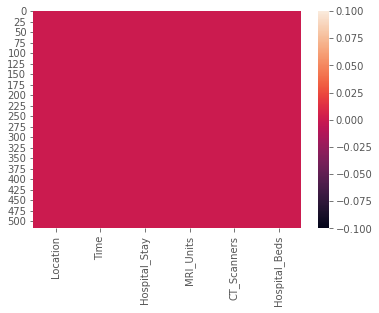

In [14]:
sns.heatmap(df.isnull());

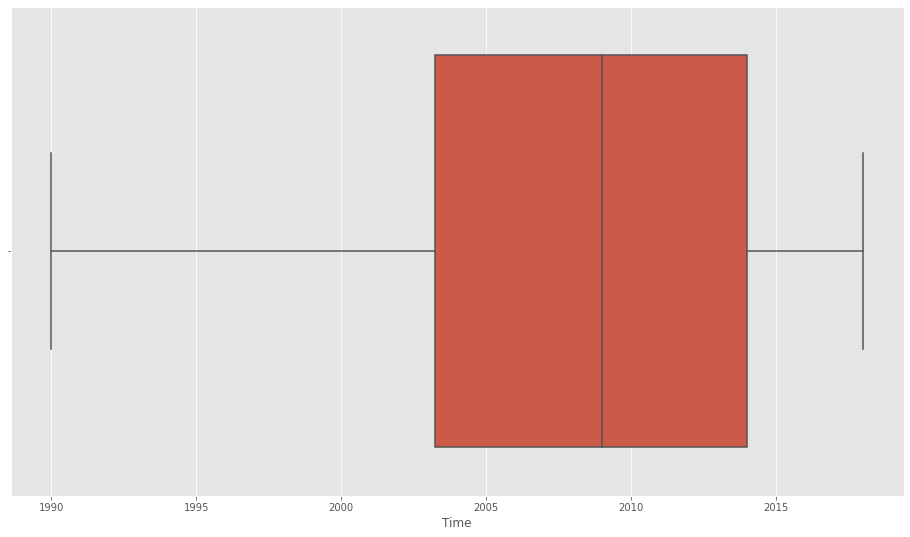

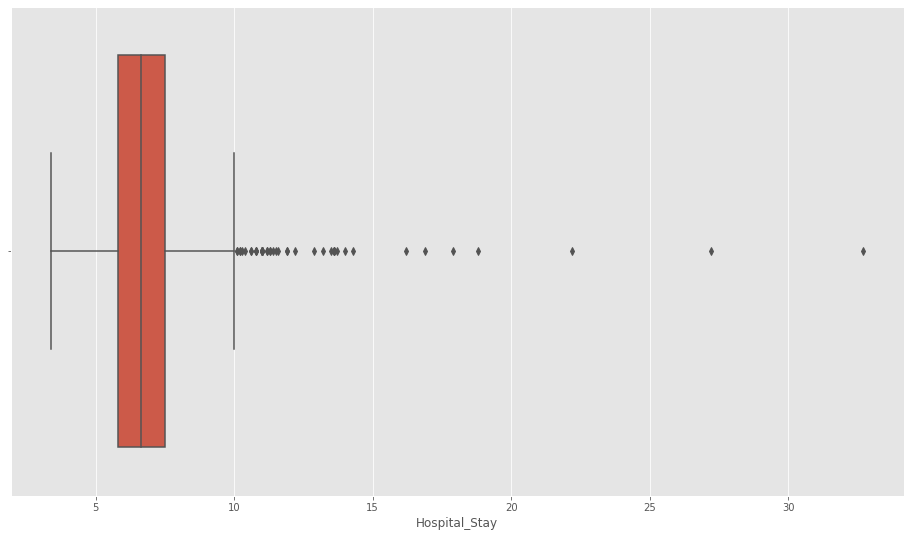

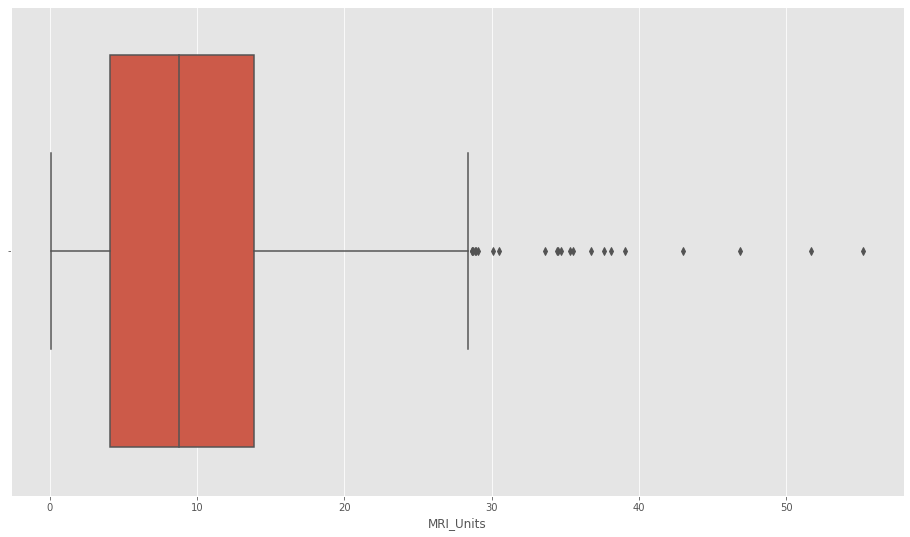

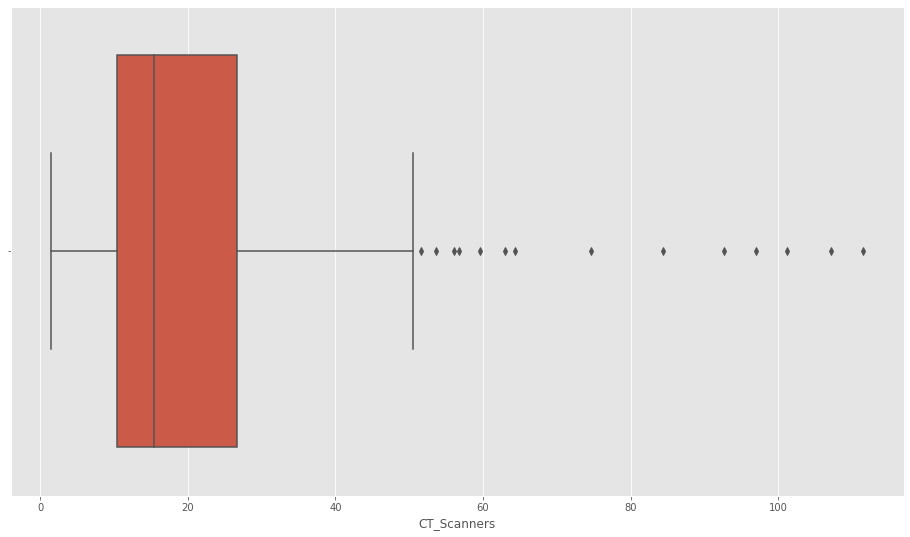

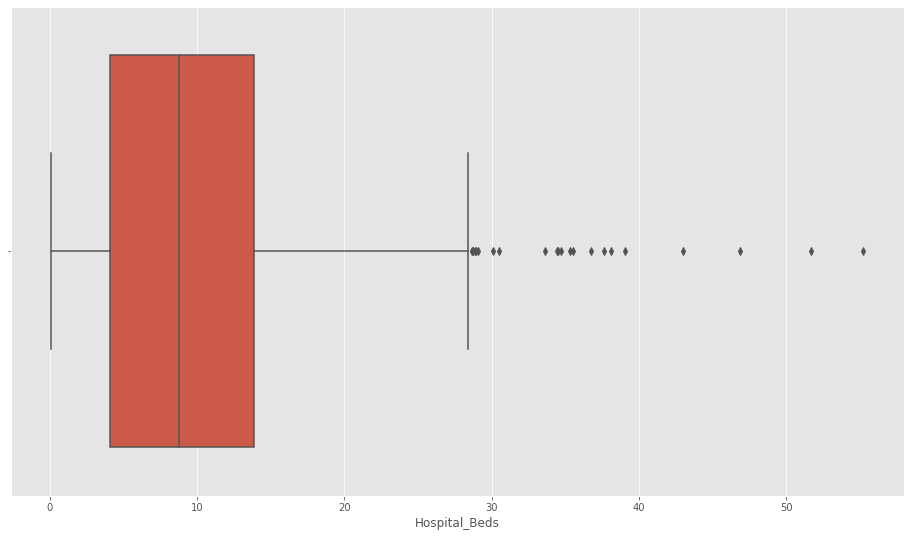

In [16]:
df1=df.select_dtypes(exclude='object')

for i in df1:
    plt.figure(figsize=(16,9))
    sns.boxplot(data=df1,x=df1[i])

In [17]:
outliers_df = pd.DataFrame(columns=df.columns)

for col in df.select_dtypes(include=np.number):
    stat = df[col].describe()
    print(stat)
    IQR = stat['75%'] - stat['25%']
    upper = stat['75%'] + 1.5 * IQR
    lower = stat['25%'] - 1.5 * IQR
    
    outliers = df[(df[col] > upper) | (df[col] < lower)]

    if not outliers.empty:
        print(f'\nOutlier found in: {col}')
        outliers_df = pd.concat([outliers_df, outliers])
    else:
        print(f'\nNo outlier found in: {col}')

    print(f'\nSuspected Outliers Lower Bound: {lower}')
    print(f'Suspected Outliers Upper Bound: {upper}\n\n')

print(f'Total Number of outlier rows: {len(outliers_df)}')


count     518.000000
mean     2007.967181
std         6.944160
min      1990.000000
25%      2003.250000
50%      2009.000000
75%      2014.000000
max      2018.000000
Name: Time, dtype: float64

No outlier found in: Time

Suspected Outliers Lower Bound: 1987.125
Suspected Outliers Upper Bound: 2030.125


count    518.000000
mean       7.140154
std        2.566864
min        3.400000
25%        5.800000
50%        6.650000
75%        7.500000
max       32.700000
Name: Hospital_Stay, dtype: float64

Outlier found in: Hospital_Stay

Suspected Outliers Lower Bound: 3.2499999999999996
Suspected Outliers Upper Bound: 10.05


count    518.000000
mean      10.565502
std        8.685570
min        0.100000
25%        4.072500
50%        8.765000
75%       13.877500
max       55.210000
Name: MRI_Units, dtype: float64

Outlier found in: MRI_Units

Suspected Outliers Lower Bound: -10.635000000000003
Suspected Outliers Upper Bound: 28.585000000000004


count    518.000000
mean      19.646718
std  

In [18]:
df.shape

(518, 6)

In [19]:
def iqr_capping(df, cols, factor):
    
    for col in cols:
        
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        
        iqr = q3 - q1
        
        upper_whisker = q3 + (factor*iqr)
        lower_whisker = q1 - (factor*iqr)
        
        df[col] = np.where(df[col]>upper_whisker, upper_whisker,
                 np.where(df[col]<lower_whisker, lower_whisker, df[col]))

In [20]:
features = [i for i in df.select_dtypes(exclude='object').columns]

In [21]:
features

['Time', 'Hospital_Stay', 'MRI_Units', 'CT_Scanners', 'Hospital_Beds']

In [22]:
iqr_capping(df, features, 1.5)

In [23]:
df.shape

(518, 6)

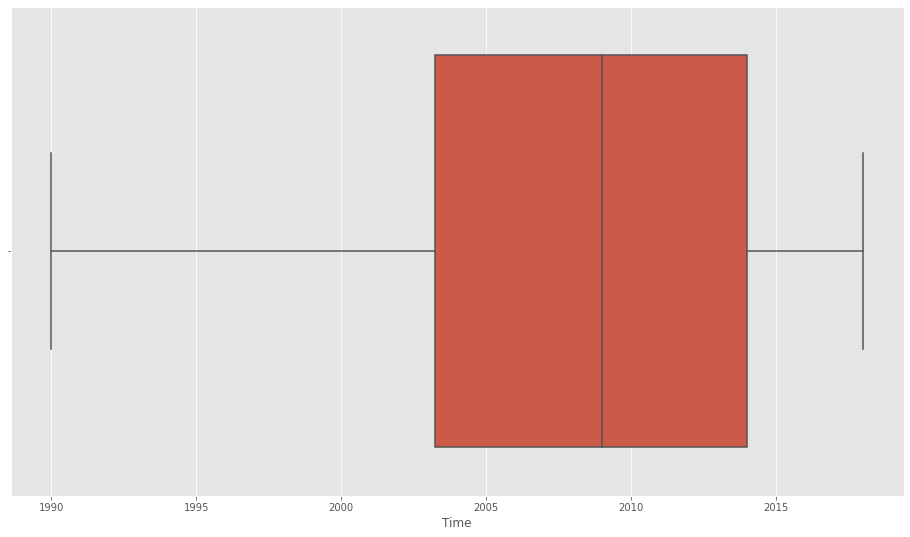

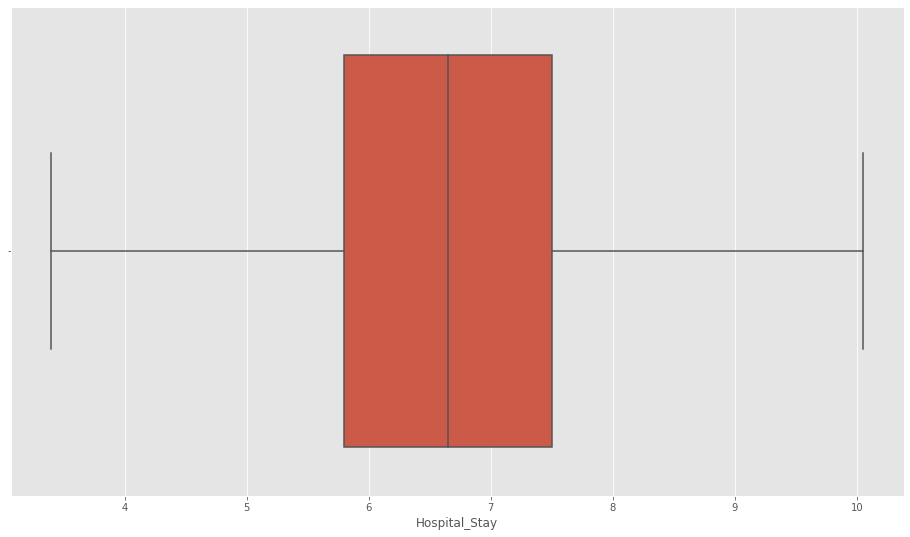

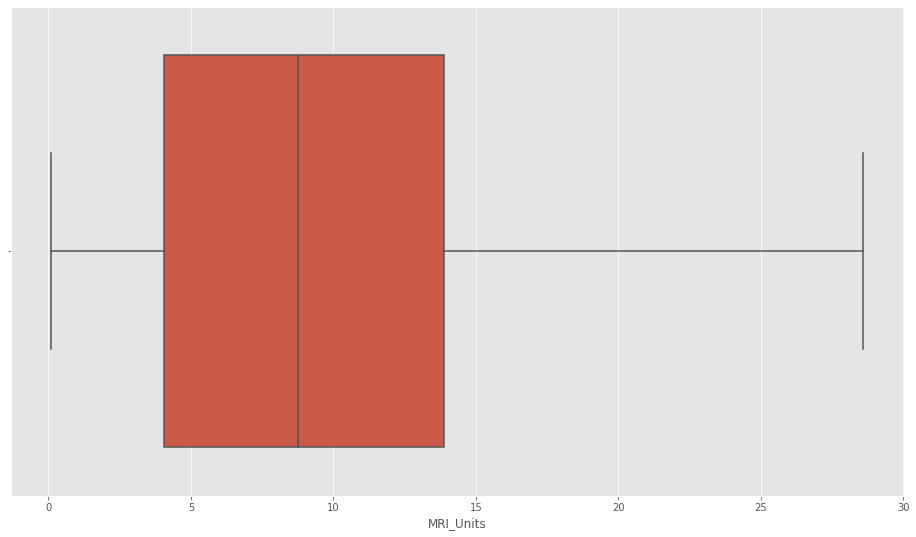

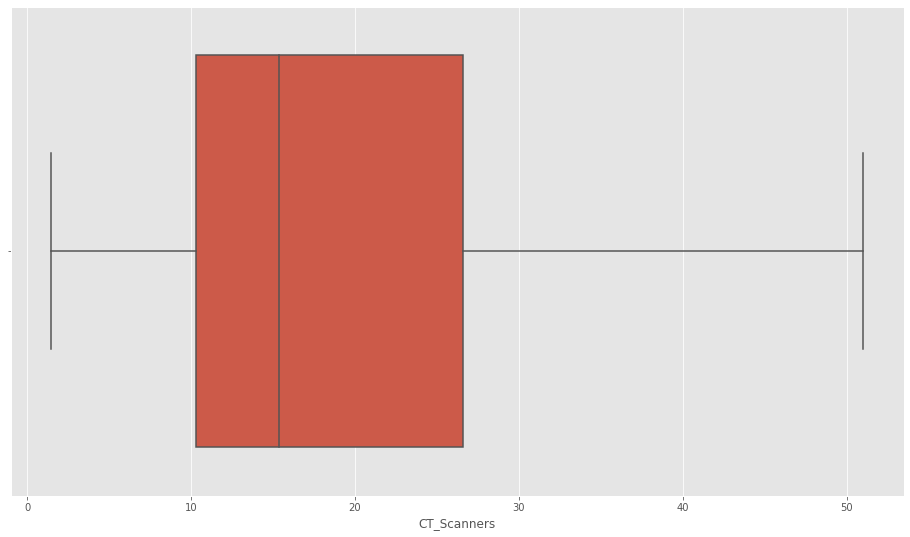

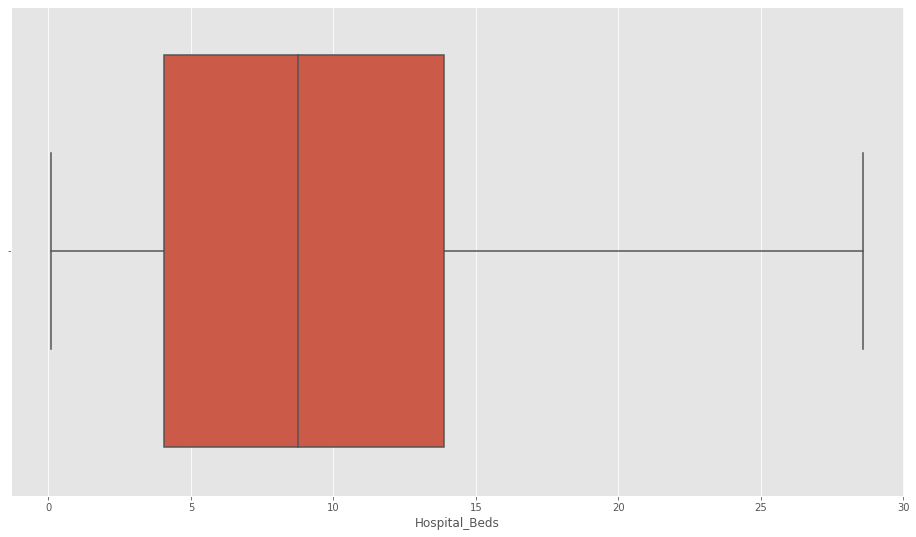

In [24]:
df2=df.select_dtypes(exclude='object')

for i in df2:
    plt.figure(figsize=(16,9))
    sns.boxplot(data=df2,x=df2[i])

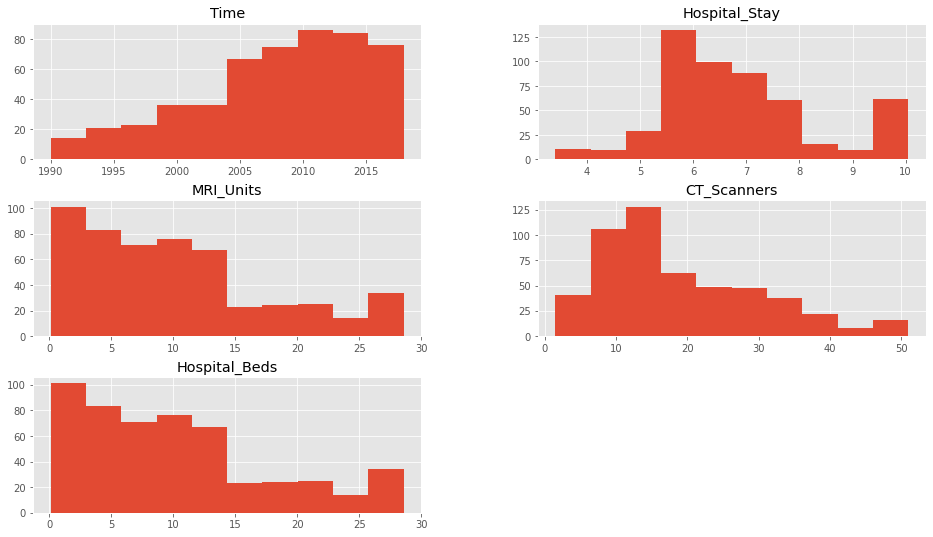

In [26]:
df.hist(figsize=(16,9));

<Figure size 1152x648 with 0 Axes>

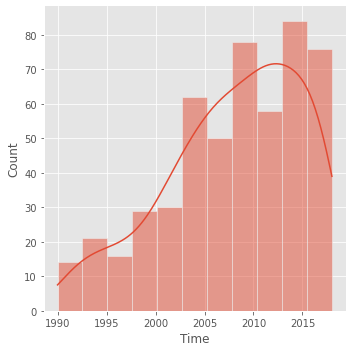

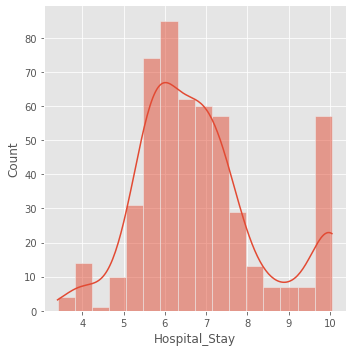

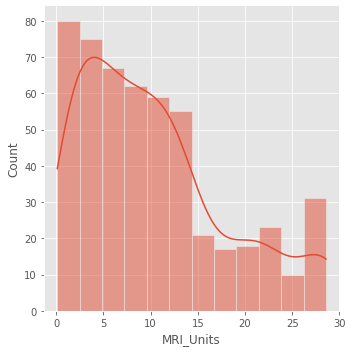

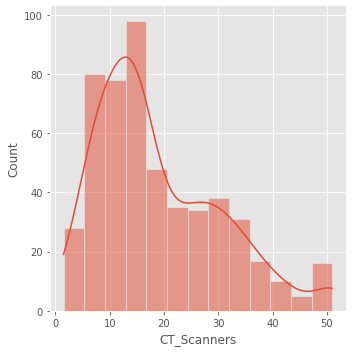

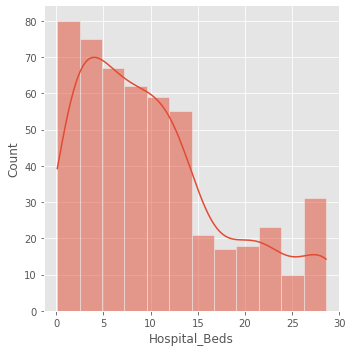

In [27]:
plt.figure(figsize=(16,9))
for i in df.select_dtypes(exclude='object'):
    sns.displot(df[i],kde=True);

In [28]:
df.sample()

,Location,Time,Hospital_Stay,MRI_Units,CT_Scanners,Hospital_Beds
218,IRL,2013.0,5.7,13.19,17.73,13.19


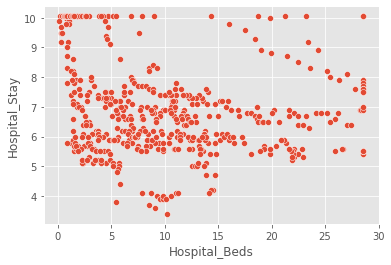

In [29]:
sns.scatterplot(data=df , x='Hospital_Beds',y='Hospital_Stay');

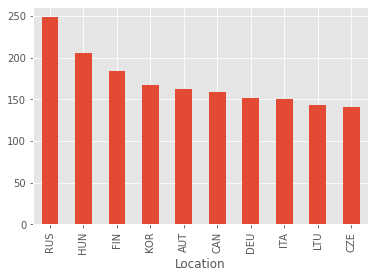

In [33]:
df.groupby('Location')['Hospital_Stay'].sum().sort_values(ascending=False).head(10).plot(kind='bar');

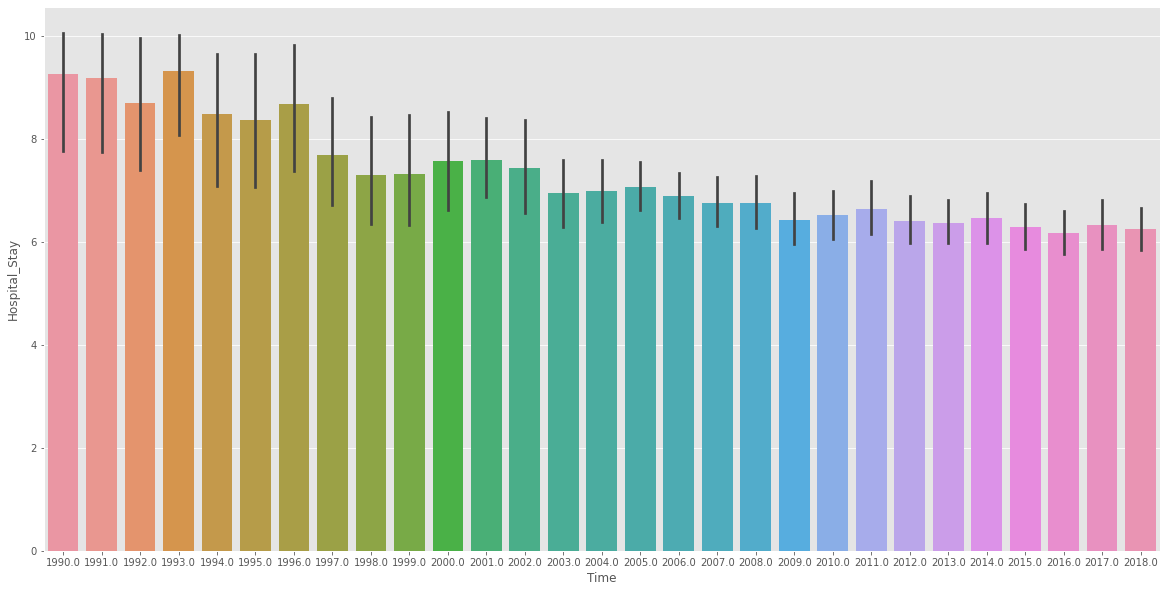

In [37]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, x='Time',y='Hospital_Stay');

In [38]:
df.sample()

,Location,Time,Hospital_Stay,MRI_Units,CT_Scanners,Hospital_Beds
329,POL,2017.0,6.6,7.93,16.88,7.93


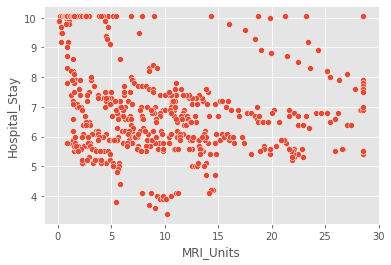

In [41]:
sns.scatterplot(data=df , x='MRI_Units',y='Hospital_Stay');


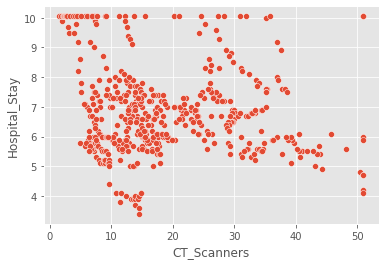

In [42]:
sns.scatterplot(data=df , x='CT_Scanners',y='Hospital_Stay');

In [44]:
df.sample()

,Location,Time,Hospital_Stay,MRI_Units,CT_Scanners,Hospital_Beds
264,KOR,2012.0,9.2,23.37,36.93,23.37


In [45]:
num_feature = df.drop('Hospital_Stay',axis=1).select_dtypes(exclude='object').columns
cat_feature = df.select_dtypes(include='object').columns

In [46]:
 numeric_transformer = Pipeline(
     steps=[ ("imputer", SimpleImputer(strategy='median'))
               , ("scaler", StandardScaler())
           ]
 )
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [47]:
categorical_transformer = Pipeline(
     steps=[
         ("imputer_cat", SimpleImputer(strategy='most_frequent')),
        ("encoder", OneHotEncoder(sparse=False,handle_unknown='ignore')),
        ("scaler", StandardScaler())
               ]
)
categorical_transformer

Pipeline(steps=[('imputer_cat', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('scaler', StandardScaler())])

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
         ("num", numeric_transformer, num_feature),
         ("cat", categorical_transformer, cat_feature),
     ]
 )
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Time', 'MRI_Units', 'CT_Scanners', 'Hospital_Beds'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Location'], dtype='object'))])

In [49]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor),
            ("model", XGBRegressor()
           
           )
          ]
 )

In [50]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Time', 'MRI_Units', 'CT_Scanners', 'Hospital_Beds'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unk...
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [51]:
X=df.drop(columns=['Hospital_Stay'])

In [52]:
y=df['Hospital_Stay']

In [53]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X, y, cv=10, scoring='r2').mean()

-0.11362111001376748

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
# train
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Time', 'MRI_Units', 'CT_Scanners', 'Hospital_Beds'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unk...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [56]:
y_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)

In [57]:
r2_score(y_train,y_train_pred)

0.9995120100162513

In [58]:
r2_score(y_test,y_pred)

0.9612210298746499